## Load documents with IDs

In [1]:
import requests 

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/documents-with-ids.json'
docs_url = f'{base_url}/{relative_url}?raw=1'
docs_response = requests.get(docs_url)
documents = docs_response.json()

In [2]:
documents[10]

{'text': 'It depends on your background and previous experience with modules. It is expected to require about 5 - 15 hours per week. [source1] [source2]\nYou can also calculate it yourself using this data and then update this answer.',
 'section': 'General course-related questions',
 'question': 'Course - \u200b\u200bHow many hours per week am I expected to spend on this  course?',
 'course': 'data-engineering-zoomcamp',
 'id': 'ea739c65'}

## Load ground truth

In [3]:
import pandas as pd

base_url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main'
relative_url = '03-vector-search/eval/ground-truth-data.csv'
ground_truth_url = f'{base_url}/{relative_url}?raw=1'

df_ground_truth = pd.read_csv(ground_truth_url)
df_ground_truth = df_ground_truth[df_ground_truth.course == 'machine-learning-zoomcamp']
ground_truth = df_ground_truth.to_dict(orient='records')

In [5]:
df_ground_truth.isnull().sum()

question    0
course      0
document    0
dtype: int64

In [6]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [7]:
doc_idx = {d['id']: d for d in documents}
doc_idx['5170565b']

{'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'section': 'General course-related questions',
 'question': 'What if I miss a session?',
 'course': 'machine-learning-zoomcamp',
 'id': '5170565b'}

In [8]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Index data

In [9]:
from sentence_transformers import SentenceTransformer

model_name = 'multi-qa-MiniLM-L6-cos-v1'
model = SentenceTransformer(model_name)

/Users/patrickcmd/Projects/personal/llm-zoomcamp/env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "text": {"type": "text"},
            "section": {"type": "text"},
            "question": {"type": "text"},
            "course": {"type": "keyword"},
            "id": {"type": "keyword"},
            "question_text_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "course-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'course-questions'})

In [11]:
from tqdm.auto import tqdm

for doc in tqdm(documents):
    question = doc['question']
    text = doc['text']
    doc['question_text_vector'] = model.encode(question + ' ' + text)

    es_client.index(index=index_name, document=doc)

100%|██████████| 948/948 [00:35<00:00, 26.88it/s]


## Retrieval

In [12]:
def elastic_search_knn(field, vector, course):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "course": course
            }
        }
    }

    search_query = {
        "knn": knn,
        "_source": ["text", "section", "question", "course", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

def question_text_vector_knn(q):
    question = q['question']
    course = q['course']

    v_q = model.encode(question)

    return elastic_search_knn('question_text_vector', v_q, course)

In [13]:
question_text_vector_knn(dict(
    question='Are sessions recorded if I miss one?',
    course='machine-learning-zoomcamp'
))

[{'question': 'What if I miss a session?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
  'id': '5170565b'},
 {'question': 'Is it going to be live? When?',
  'course': 'machine-learning-zoomcamp',
  'section': 'General course-related questions',
  'text': 'The course videos are pre-recorded, you can start watching the course right now.\nWe will also occasionally have office hours - live sessions where we will answer your questions. The office hours sessions are recorded too.\nYou can see the office hours as well as the pre-recorded course videos in the course playlist on YouTube.',
  'id': '39fda9f0'},
 {'question': 'The same accuracy on epochs',
  'course': 'machine-learning-zoomcamp',
  'section': '8. Neural Networks an

## The RAG flow

In [14]:
def build_prompt(query, search_results):
    prompt_template = """
You're a course teaching assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
Use only the facts from the CONTEXT when answering the QUESTION.

QUESTION: {question}

CONTEXT: 
{context}
""".strip()

    context = ""
    
    for doc in search_results:
        context = context + f"section: {doc['section']}\nquestion: {doc['question']}\nanswer: {doc['text']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt

In [15]:
import os
from groq import Groq
from dotenv import load_dotenv

load_dotenv()

client = Groq(
    api_key=os.environ.get("GROQ_API_KEY"),
)

def llm(prompt, model='llama3-8b-8192'):
    response = client.chat.completions.create(
        model=model,
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

In [16]:
# previously: rag(query: str) -> str
def rag(query: dict, model='llama3-8b-8192') -> str:
    search_results = question_text_vector_knn(query)
    prompt = build_prompt(query['question'], search_results)
    answer = llm(prompt, model=model)
    return answer

In [17]:
ground_truth[10]

{'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp',
 'document': '5170565b'}

In [24]:
rag(ground_truth[10])

'Based on the CONTEXT, I can answer the QUESTION:\n\nAre sessions recorded if I miss one?\n\nThe answer is YES, sessions are recorded. According to the context, "Everything is recorded, so you won’t miss anything." Also, it is mentioned that "office hours sessions are recorded too" and "The course videos are pre-recorded".'

In [25]:
doc_idx['5170565b']['text']

'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

## Cosine similarity metric

In [29]:
answer_llm = 'Based on the CONTEXT, I can answer the QUESTION:\n\nAre sessions recorded if I miss one?\n\nThe answer is YES, sessions are recorded. According to the context, "Everything is recorded, so you won’t miss anything." Also, it is mentioned that "office hours sessions are recorded too" and "The course videos are pre-recorded".'
answer_orig = 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.'

v_llm = model.encode(answer_llm)
v_orig = model.encode(answer_orig)

v_llm.dot(v_orig)

0.5404092

In [30]:
ground_truth[0]

{'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp',
 'document': '0227b872'}

In [31]:
len(ground_truth)

1830

In [33]:
answers = {}

In [38]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

100%|██████████| 1830/1830 [14:08<00:00,  2.16it/s]  


In [41]:
len(answers)

1830

In [39]:
answers[1]

{'answer_llm': 'Based on the provided CONTEXT, I will answer the QUESTION:\n\nQUESTION: Can you provide a link to sign up?\n\nANSWER: Unfortunately, the FAQ does not provide a link to sign up. However, it mentions that you can find the link in the course GitHub repository, which is https://airtable.com/shryxwLd0COOEaqXo.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Can you provide a link to sign up?',
 'course': 'machine-learning-zoomcamp'}

In [40]:
answers[100]

{'answer_llm': 'Based on the CONTEXT, I would answer the QUESTION as follows:\n\nWe won’t be releasing new course videos. According to the previous answer, "We won’t re-record the course videos. The focus of the course and the skills we want to teach remained the same, and the videos are still up-to-date." This implies that we will be using the same videos from 2021.',
 'answer_orig': 'We won’t re-record the course videos. The focus of the course and the skills we want to teach remained the same, and the videos are still up-to-date.\nIf you haven’t taken part in the previous iteration, you can start watching the videos. It’ll be useful for you and you will learn new things. However, we recommend using Python 3.10 now instead of Python 3.8.',
 'document': 'e7ba6b8a',
 'question': 'Will you be releasing new course videos or using the ones from 2021?',
 'course': 'machine-learning-zoomcamp'}

In [42]:
results_llama3_8b_8192 = [None] * len(ground_truth)

for i, val in answers.items():
    results_llama3_8b_8192[i] = val.copy()
    results_llama3_8b_8192[i].update(ground_truth[i])

In [43]:
results_llama3_8b_8192[0]

{'answer_llm': 'According to the context, you can sign up for the course by going to the course page at http://mlzoomcamp.com/.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [46]:
answers[0]

{'answer_llm': 'According to the context, you can sign up for the course by going to the course page at http://mlzoomcamp.com/.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [47]:
results_llama3_8b_8192[-1]

{'answer_llm': 'Who suggested showcasing progress through LinkedIn posts?\n\nAnswer: Based on the provided context, Annaliese Bronz (in the Miscellaneous section) suggested showcasing progress through LinkedIn posts. She stated: "By putting the link of my project into my CV as showcase and make posts to show my progress."',
 'answer_orig': 'I’ve seen LinkedIn users list DataTalksClub as Experience with titles as:\nMachine Learning Fellow\nMachine Learning Student\nMachine Learning Participant\nMachine Learning Trainee\nPlease note it is best advised that you do not list the experience as an official “job” or “internship” experience since DataTalksClub did not hire you, nor financially compensate you.\nOther ways you can incorporate the experience in the following sections:\nOrganizations\nProjects\nSkills\nFeatured\nOriginal posts\nCertifications\nCourses\nBy Annaliese Bronz\nInteresting question, I put the link of my project into my CV as showcase and make posts to show my progress.\n

### Saving resutls to csv

In [48]:
import pandas as pd

In [49]:
df_llama3_8b_8192 = pd.DataFrame(results_llama3_8b_8192)

In [50]:
df_llama3_8b_8192.shape

(1830, 5)

In [51]:
df_llama3_8b_8192.head()

,answer_llm,answer_orig,document,question,course
0,"According to the context, you can sign up for ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,"Based on the provided CONTEXT, I will answer t...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Based on the CONTEXT, we can infer that there ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,"Based on the provided context, there is no dir...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,"Based on the provided context, here's how you ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [52]:
df_llama3_8b_8192.tail()

,answer_llm,answer_orig,document,question,course
1825,"Based on the CONTEXT, here are some suggested ...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,What are some suggested titles for listing the...,machine-learning-zoomcamp
1826,"Based on the context, it is NOT recommended to...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Should I list the Machine Learning Zoomcamp ex...,machine-learning-zoomcamp
1827,"According to the FAQ database, you can incorpo...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,In which LinkedIn sections can I incorporate m...,machine-learning-zoomcamp
1828,"According to the context, Ani Mkrtumyan gave a...",I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who gave advice on including a project link in...,machine-learning-zoomcamp
1829,Who suggested showcasing progress through Link...,I’ve seen LinkedIn users list DataTalksClub as...,c6a22665,Who suggested showcasing progress through Link...,machine-learning-zoomcamp


In [54]:
!mkdir data

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


mkdir: data: File exists


In [55]:
df_llama3_8b_8192.to_csv('data/results-llama3_8b_8192.csv', index=False)

## Evaluating Gemma 7B

In [73]:
rag(ground_truth[10], model='gemma-7b-it')

'Yes, all sessions, including office hours, are recorded and available for viewing on YouTube. You will be able to catch up on any missed content and ask your questions during office hours or through Slack.'

### Making the execution a bit faster with concurrency

**Note**: It may cause rate limits

In [ ]:
from tqdm.auto import tqdm

from concurrent.futures import ThreadPoolExecutor

pool = ThreadPoolExecutor(max_workers=6)

def map_progress(pool, seq, f):
    """
    Applies a function to each element in a sequence using a thread pool, with a progress bar.

    Parameters:
    pool (ThreadPoolExecutor): The thread pool executor to manage concurrent execution.
    seq (iterable): A sequence of elements to which the function `f` will be applied.
    f (callable): A function to apply to each element in `seq`.

    Returns:
    list: A list containing the results of applying `f` to each element in `seq`.
    
    Example:
    >>> from concurrent.futures import ThreadPoolExecutor
    >>> from tqdm.auto import tqdm
    >>> pool = ThreadPoolExecutor(max_workers=6)
    >>> seq = [1, 2, 3, 4, 5]
    >>> def square(x):
    ...     return x * x
    >>> results = map_progress(pool, seq, square)
    >>> print(results)
    [1, 4, 9, 16, 25]
    """
    results = []

    with tqdm(total=len(seq)) as progress:
        futures = []

        for el in seq:
            future = pool.submit(f, el)
            future.add_done_callback(lambda p: progress.update())
            futures.append(future)

        for future in futures:
            result = future.result()
            results.append(result)

    return results


In [74]:
def process_record(rec):
    model = 'gemma-7b-it'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [75]:
process_record(ground_truth[10])

{'answer_llm': 'Yes, all sessions are recorded. You can watch the recorded sessions on the course playlist on YouTube.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

#### Executing code below raises rate limit

In [64]:
results_gemma_7b_it = map_progress(pool, ground_truth, process_record) # this causes a rate limit. Can't execute for now

# Error code: 429 - {'error': {'message': 'Rate limit reached for model `gemma-7b-it` in organization `org_01j130bdree30trd0vfw8gs0c1` on tokens per minute (TPM): Limit 5000, Used 4747, Requested 737. 
# Please try again in 5.805s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}

#### Executing using a for loop as before

In [76]:
import time

In [77]:
answers_gemma_7b_it = {}

In [79]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers_gemma_7b_it:
        continue

    answers_gemma_7b_it[i] = process_record(rec)
    # time.sleep(2)

100%|██████████| 1830/1830 [1:41:33<00:00,  3.33s/it]


In [80]:
len(answers_gemma_7b_it)

1830

In [84]:
answers_gemma_7b_it[10]

{'answer_llm': 'Yes, all sessions, including office hours, are recorded. You can watch the recordings on YouTube in the course playlist.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [86]:
answers_gemma_7b_it[100]

{'answer_llm': 'The course videos are from the previous iteration and will not be re-recorded. The focus of the course remains the same, and the videos are still relevant. The course is available in self-paced mode, so you can watch it at any time.',
 'answer_orig': 'We won’t re-record the course videos. The focus of the course and the skills we want to teach remained the same, and the videos are still up-to-date.\nIf you haven’t taken part in the previous iteration, you can start watching the videos. It’ll be useful for you and you will learn new things. However, we recommend using Python 3.10 now instead of Python 3.8.',
 'document': 'e7ba6b8a',
 'question': 'Will you be releasing new course videos or using the ones from 2021?',
 'course': 'machine-learning-zoomcamp'}

In [87]:
results_gemma_7b_it = [None] * len(ground_truth)

for i, val in answers_gemma_7b_it.items():
    results_gemma_7b_it[i] = val.copy()
    results_gemma_7b_it[i].update(ground_truth[i])

In [88]:
results_gemma_7b_it[10]

{'answer_llm': 'Yes, all sessions, including office hours, are recorded. You can watch the recordings on YouTube in the course playlist.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [89]:
import pandas as pd

In [90]:
df_gemma_7b_it = pd.DataFrame(results_gemma_7b_it)


In [91]:
df_gemma_7b_it.shape

(1830, 5)

In [92]:
df_gemma_7b_it.head()

,answer_llm,answer_orig,document,question,course
0,The provided text does not contain information...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,The provided text does not include any informa...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Based on the provided context, there is no spe...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The provided text indicates that students are ...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,The provided text does not contain any informa...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [93]:
df_gemma_7b_it.to_csv('data/results-gemma_7b_it.csv', index=False)

In [95]:
!head data/results-gemma_7b_it.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


answer_llm,answer_orig,document,question,course
"The provided text does not contain information regarding the submission of GitHub links for homework questions, so I am unable to answer this question from the given context.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:
Data Engineering Zoomcamp FAQ
In the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo
work",0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
"The provided text does not include any information regarding a sign-up link, so I am unable to provide the requested information from the given context.","Machine Learning Zoomcamp FAQ
The purpose of this document is to capture frequently asked technical questions.
We did this for our data engineering

## Cosine similarity

A->Q->A' cosine similarity

A -> Q -> A'

cosine(A, A')

### llama3-8b-8192

In [97]:
results_llama3_8b_8192 = df_llama3_8b_8192.to_dict(orient='records')

In [98]:
record = results_llama3_8b_8192[0]

In [99]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [100]:
compute_similarity(record)

0.336047

In [101]:
similarity = []

for record in tqdm(results_llama3_8b_8192):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|██████████| 1830/1830 [01:46<00:00, 17.23it/s]


In [102]:
df_llama3_8b_8192['cosine'] = similarity
df_llama3_8b_8192['cosine'].describe()

count    1830.000000
mean        0.639097
std         0.219019
min        -0.138983
25%         0.531044
50%         0.690447
75%         0.797554
max         0.970666
Name: cosine, dtype: float64

In [103]:
import seaborn as sns

### gemma-7b-it

In [104]:
results_gemma_7b_it = df_gemma_7b_it.to_dict(orient='records')

similarity_gemma_7b_it = []

for record in tqdm(results_gemma_7b_it):
    sim = compute_similarity(record)
    similarity_gemma_7b_it.append(sim)

100%|██████████| 1830/1830 [01:30<00:00, 20.17it/s]


In [105]:
df_gemma_7b_it['cosine'] = similarity_gemma_7b_it
df_gemma_7b_it['cosine'].describe()

count    1830.000000
mean        0.624714
std         0.221743
min        -0.124406
25%         0.507733
50%         0.670313
75%         0.787382
max         0.972301
Name: cosine, dtype: float64

In [106]:
import matplotlib.pyplot as plt

### gemma2-9b-it

In [107]:
def process_record_gemma2_9b_it(rec):
    model = 'gemma2-9b-it'
    answer_llm = rag(rec, model=model)
    
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['text']

    return {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'document': doc_id,
        'question': rec['question'],
        'course': rec['course'],
    }

In [110]:
process_record_gemma2_9b_it(ground_truth[10])

{'answer_llm': 'Yes, the office hours sessions are recorded. \n',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [116]:
"""

results_gemma2_9b_it = []

for record in tqdm(ground_truth):
    result = process_record_gemma2_9b_it(record)
    results_gemma2_9b_it.append(result)
"""

'\n\nresults_gemma2_9b_it = []\n\nfor record in tqdm(ground_truth):\n    result = process_record_gemma2_9b_it(record)\n    results_gemma2_9b_it.append(result)\n'

In [114]:
answers_gemma2_9b_it = {}

In [120]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers_gemma2_9b_it:
        continue

    answers_gemma2_9b_it[i] = process_record_gemma2_9b_it(rec)

100%|██████████| 1830/1830 [1:39:20<00:00,  3.26s/it]  


In [121]:
len(answers_gemma2_9b_it)

1830

In [122]:
answers_gemma2_9b_it[0]

{'answer_llm': "The provided context doesn't say where to sign up for the course. \n\n\n",
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [123]:
answers_gemma2_9b_it[10]

{'answer_llm': 'Office hours sessions are recorded. \n',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [124]:
results_gemma2_9b_it = [None] * len(ground_truth)

for i, val in answers_gemma_7b_it.items():
    results_gemma2_9b_it[i] = val.copy()
    results_gemma2_9b_it[i].update(ground_truth[i])

In [125]:
results_gemma2_9b_it[0]

{'answer_llm': 'The provided text does not contain information regarding the submission of GitHub links for homework questions, so I am unable to answer this question from the given context.',
 'answer_orig': 'Machine Learning Zoomcamp FAQ\nThe purpose of this document is to capture frequently asked technical questions.\nWe did this for our data engineering course and it worked quite well. Check this document for inspiration on how to structure your questions and answers:\nData Engineering Zoomcamp FAQ\nIn the course GitHub repository there’s a link. Here it is: https://airtable.com/shryxwLd0COOEaqXo\nwork',
 'document': '0227b872',
 'question': 'Where can I sign up for the course?',
 'course': 'machine-learning-zoomcamp'}

In [126]:
results_gemma2_9b_it[10]

{'answer_llm': 'Yes, all sessions, including office hours, are recorded. You can watch the recordings on YouTube in the course playlist.',
 'answer_orig': 'Everything is recorded, so you won’t miss anything. You will be able to ask your questions for office hours in advance and we will cover them during the live stream. Also, you can always ask questions in Slack.',
 'document': '5170565b',
 'question': 'Are sessions recorded if I miss one?',
 'course': 'machine-learning-zoomcamp'}

In [127]:
df_gemma2_9b_it = pd.DataFrame(results_gemma2_9b_it)


In [128]:
df_gemma2_9b_it.shape

(1830, 5)

In [129]:
df_gemma2_9b_it.head()

,answer_llm,answer_orig,document,question,course
0,The provided text does not contain information...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,The provided text does not include any informa...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Based on the provided context, there is no spe...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The provided text indicates that students are ...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,The provided text does not contain any informa...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp


In [130]:
df_gemma2_9b_it.to_csv('data/results-gemma2_9b_it.csv', index=False)

In [131]:
similarity_gemma2_9b_it = []

for record in tqdm(results_gemma2_9b_it):
    sim = compute_similarity(record)
    similarity_gemma2_9b_it.append(sim)

100%|██████████| 1830/1830 [01:37<00:00, 18.84it/s]


In [132]:
df_gemma2_9b_it['cosine'] = similarity_gemma2_9b_it
df_gemma2_9b_it['cosine'].describe()

count    1830.000000
mean        0.624714
std         0.221743
min        -0.124406
25%         0.507733
50%         0.670313
75%         0.787382
max         0.972301
Name: cosine, dtype: float64


### RAG LLM performance

/var/folders/p2/bntnb9nj3c56rqj3dvd7fnqc0000gn/T/ipykernel_16581/21358560.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_llama3_8b_8192['cosine'], label='llama3-8b-8192', color='blue')
/var/folders/p2/bntnb9nj3c56rqj3dvd7fnqc0000gn/T/ipykernel_16581/21358560.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750b

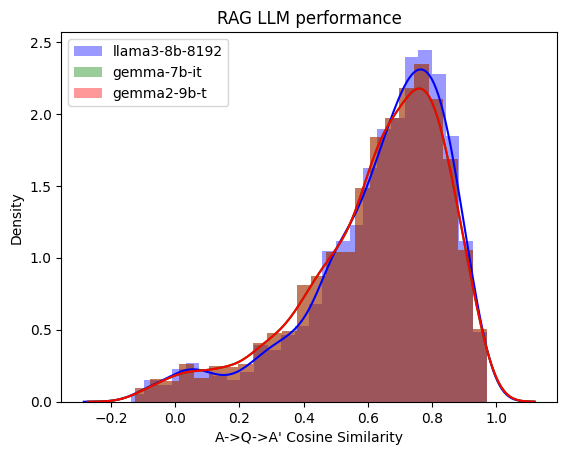

In [135]:
sns.distplot(df_llama3_8b_8192['cosine'], label='llama3-8b-8192', color='blue')
sns.distplot(df_gemma_7b_it['cosine'], label='gemma-7b-it', color='green')
sns.distplot(df_gemma2_9b_it['cosine'], label='gemma2-9b-t', color='red')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

plt.show()

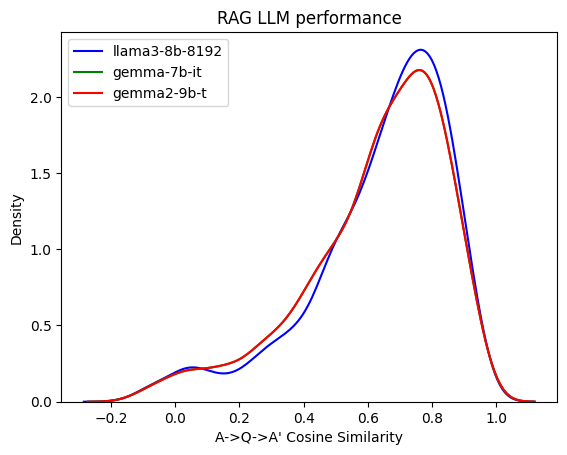

In [136]:
sns.kdeplot(df_llama3_8b_8192['cosine'], label='llama3-8b-8192', color='blue')
sns.kdeplot(df_gemma_7b_it['cosine'], label='gemma-7b-it', color='green')
sns.kdeplot(df_gemma2_9b_it['cosine'], label='gemma2-9b-t', color='red')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

plt.show()

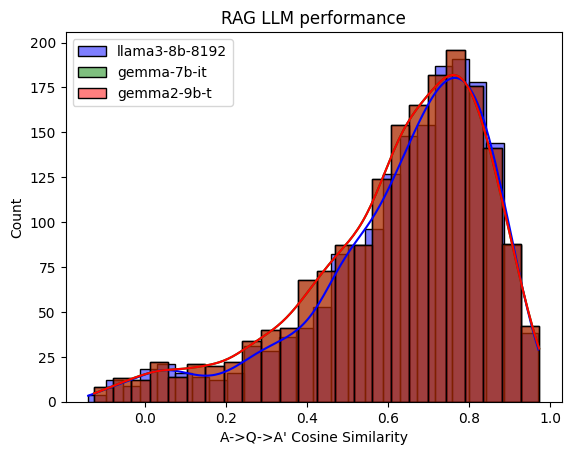

In [137]:
sns.histplot(df_llama3_8b_8192['cosine'], label='llama3-8b-8192', color='blue', kde=True)
sns.histplot(df_gemma_7b_it['cosine'], label='gemma-7b-it', color='green', kde=True)
sns.histplot(df_gemma2_9b_it['cosine'], label='gemma2-9b-t', color='red', kde=True)

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

plt.show()

## LLM-as-a-Judge

In [138]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [139]:
df_sample = df_gemma2_9b_it.sample(n=150, random_state=1)

In [140]:
df_sample.head()

,answer_llm,answer_orig,document,question,course,cosine
726,The syntax for using precision_recall_fscore_s...,Scikit-learn offers another way: precision_rec...,403bbdd8,What is the syntax for using precision_recall_...,machine-learning-zoomcamp,0.772784
1662,**How to modify scripts to avoid pickle errors...,When running a docker container with waitress ...,236864c2,How should I modify my scripts to avoid pickle...,machine-learning-zoomcamp,0.742242
834,The command `docker run -it --entrypoint bash ...,Launch the container image in interactive mode...,63a81b57,What command launches a container image in int...,machine-learning-zoomcamp,0.867766
1234,"**Yes, you can make a pull request with the Py...",Pytorch is also a deep learning framework that...,c4ff26e5,Can we make a pull request for homework soluti...,machine-learning-zoomcamp,0.560884
1323,"Based on the provided context, several potenti...",When running docker build -t dino-dragon-model...,42c09143,What might be the cause of the pip version err...,machine-learning-zoomcamp,0.388002


In [141]:
samples = df_sample.to_dict(orient='records')

In [142]:
record = samples[0]
record

{'answer_llm': 'The syntax for using precision_recall_fscore_support in Python is:\n\n```python\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n```\n\nThe function takes three arguments:\n\n* `y_val`: The true labels.\n* `y_val_pred`: The predicted labels.\n* `zero_division`: An optional argument that controls the behavior when encountering zero values.',
 'answer_orig': 'Scikit-learn offers another way: precision_recall_fscore_support\nExample:\nfrom sklearn.metrics import precision_recall_fscore_support\nprecision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)\n(Gopakumar Gopinathan)',
 'document': '403bbdd8',
 'question': 'What is the syntax for using precision_recall_fscore_support in Python?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.7727841138839722}

In [143]:
prompt = prompt1_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: Scikit-learn offers another way: precision_recall_fscore_support
Example:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
(Gopakumar Gopinathan)
Generated Question: What is the syntax for using precision_recall_fscore_support in Python?
Generated Answer: The syntax for using precision_recall_fscore_support in Python is:

```python
precision, recall, fscore, support = precision_recall_fscore_support(y_val, y_val_pred, zero_division=0)
```

The function takes three arguments:

* `y_val

In [144]:
answer = llm(prompt, model='gemma2-9b-it')

In [150]:
print(answer.replace("json", "", 1).replace("```", ""))


{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer accurately provides the syntax for using the `precision_recall_fscore_support` function in Python, matching the information given in the original answer."
}
 



In [148]:
import json

In [151]:
print(answer.replace("json", "", 1).replace("```", ""))


{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer accurately provides the syntax for using the `precision_recall_fscore_support` function in Python, matching the information given in the original answer."
}
 



In [152]:
len(samples)

150

In [153]:
evaluations = []

for record in tqdm(samples):
    prompt = prompt1_template.format(**record)
    evaluation = llm(prompt, model='gemma2-9b-it')
    evaluations.append(evaluation)

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [06:12<00:00,  2.48s/it]


In [155]:
print(evaluations[0])

```json
{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer provides the correct syntax for using the precision_recall_fscore_support function from scikit-learn, along with a description of the arguments. This directly addresses the information given in the original answer."
}
```


In [158]:
json_evaluations = []

for i, str_eval in enumerate(evaluations):
    try:
        str_eval = str_eval.replace("json", "", 1).replace("```", "")
        json_eval = json.loads(str_eval)
        json_evaluations.append(json_eval)
    except Exception as e:
        print(str(e))
        print(str_eval)

Extra data: line 9 column 1 (char 366)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the user's question about reading data from a GitHub URL using pandas. It provides two methods, one mirroring the original answer's approach and another demonstrating a download method.  Both methods are relevant to the query and thus the answer is considered RELEVANT." 
}
 


Let me know if you'd like me to evaluate another example!
Invalid control character at: line 3 column 256 (char 291)
{
  "Relevance": "PARTLY_RELEVANT",
  "Explanation": "The generated answer touches upon some relevant points, mentioning the need to potentially convert a NumPy array to a list and to address special characters in feature names.  However, it misses crucial details from the original answer: 
  - It doesn't explain the exact error message (`ValueError: feature_names must be string, and may not contain [, ] or <`)  
  - It lacks the context about `dv.get_feature_names_out()` r

In [159]:
print(json_evaluations[0])

{'Relevance': 'RELEVANT', 'Explanation': 'The generated answer provides the correct syntax for using the precision_recall_fscore_support function from scikit-learn, along with a description of the arguments. This directly addresses the information given in the original answer.'}


In [160]:
df_evaluations = pd.DataFrame(json_evaluations)

In [161]:
df_evaluations.head()

,Relevance,Explanation
0,RELEVANT,The generated answer provides the correct synt...
1,RELEVANT,The generated answer accurately identifies the...
2,PARTLY_RELEVANT,The generated answer correctly identifies the ...
3,RELEVANT,The generated answer directly addresses the us...
4,NON_RELEVANT,The generated answer focuses on potential caus...


In [162]:
df_evaluations.shape

(148, 2)

In [163]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           64
PARTLY_RELEVANT    59
NON_RELEVANT       25
Name: count, dtype: int64

In [164]:
df_evaluations[df_evaluations.Relevance == 'NON_RELEVANT'] #.to_dict(orient='records')

,Relevance,Explanation
4,NON_RELEVANT,The generated answer focuses on potential caus...
5,NON_RELEVANT,The generated answer provides a different comm...
11,NON_RELEVANT,The generated answer addresses a different iss...
16,NON_RELEVANT,The generated answer states it cannot answer t...
22,NON_RELEVANT,The generated answer does not provide a video ...
24,NON_RELEVANT,The generated answer correctly states that it ...
40,NON_RELEVANT,The generated answer focuses on setting up a C...
50,NON_RELEVANT,The generated answer does not address the data...
53,NON_RELEVANT,The generated answer states it cannot answer t...
60,NON_RELEVANT,The generated answer fails to address the ques...


In [166]:
samples[4]

{'answer_llm': 'Based on the provided context, several potential causes could explain the pip version error:\n\n**1. Version conflicts in dependencies:**\n\n- The warning message suggests a conflict between different versions of Scikit-Learn being used in the project. \n- This could be due to installing different versions of Scikit-Learn in different environments or having incompatible dependencies in the Pipfile.\n\n\n**2. Mismatch between model and libraries:**\n\n- The context mentions creating the model with one version of Scikit-Learn (1.1.1) but using another version (0.24.2) during deployment. \n- This mismatch can lead to compatibility issues and unpredictable behavior.\n\n\n**3. Pipfile configuration issues:**\n\n- The context suggests encountering issues when installing a specific version of Scikit-Learn (1.0.2). \n- This could be due to an incompatibility with the current Pipfile configuration or environment settings.\n\n\n**4. Invalid environment configuration:**\n\n- The c

In [167]:
prompt = prompt2_template.format(**record)
print(prompt)

You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: What modification was made to the median_house_value target in the homework?
Generated Answer: The median_house_value target in the homework was modified to binary format, making its values discrete (0 or 1), in order to calculate the mutual information score, which is appropriate for categorical or discrete variables.

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}


In [168]:
evaluation = llm(prompt, model='gemma2-9b-it')
print(evaluation)

{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question by stating the modification made to the median_house_value target, which was changed to a binary format." 
} 



In [169]:
evaluations_2 = []

for record in tqdm(samples):
    prompt = prompt2_template.format(**record)
    evaluation = llm(prompt, model='gemma2-9b-it')
    evaluations_2.append(evaluation)

100%|██████████| 150/150 [06:04<00:00,  2.43s/it]


In [170]:
print(evaluations_2[0])

```json
{
  "Relevance": "RELEVANT",
  "Explanation": "The generated answer directly addresses the question by providing the correct syntax for the `precision_recall_fscore_support` function in Python. It also includes a clear explanation of the function's arguments."
}
``` 



In [171]:
json_evaluations_2 = []

for i, str_eval in enumerate(evaluations_2):
    try:
        str_eval = str_eval.replace("json", "", 1).replace("```", "")
        json_eval = json.loads(str_eval)
        json_evaluations_2.append(json_eval)
    except Exception as e:
        print(str(e))
        print(str_eval)

In [172]:
json_evaluations_2[0]

{'Relevance': 'RELEVANT',
 'Explanation': "The generated answer directly addresses the question by providing the correct syntax for the `precision_recall_fscore_support` function in Python. It also includes a clear explanation of the function's arguments."}

In [173]:
df_evaluations_2 = pd.DataFrame(json_evaluations_2)

In [174]:
df_evaluations_2.head()

,Relevance,Explanation
0,RELEVANT,The generated answer directly addresses the qu...
1,RELEVANT,The generated answer directly addresses the us...
2,RELEVANT,The generated answer correctly identifies the ...
3,PARTLY_RELEVANT,While the answer acknowledges the possibility ...
4,RELEVANT,The generated answer directly addresses the qu...


In [175]:
df_evaluations_2[df_evaluations_2.Relevance == 'NON_RELEVANT']

,Relevance,Explanation
11,NON_RELEVANT,"The generated answer refers to section 10, whi..."
16,NON_RELEVANT,While the generated answer acknowledges the qu...
23,NON_RELEVANT,The answer explicitly states it cannot provide...
24,NON_RELEVANT,The answer explicitly states that it cannot pr...
25,NON_RELEVANT,The generated answer acknowledges that it does...
27,NON_RELEVANT,The generated answer explicitly states that it...
45,NON_RELEVANT,The answer explicitly states that it cannot pr...
49,NON_RELEVANT,The answer states that it cannot find informat...
55,NON_RELEVANT,The generated answer acknowledges that it cann...
62,NON_RELEVANT,The generated answer states that it doesn't ha...


In [176]:
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           92
PARTLY_RELEVANT    31
NON_RELEVANT       27
Name: count, dtype: int64

In [177]:
samples[45]

{'answer_llm': 'The provided text does not contain any information regarding the commands to start the docker daemon on Linux, so I am unable to answer this question from the given context.',
 'answer_orig': 'Working on getting Docker installed - when I try running hello-world I am getting the error.\nDocker: Cannot connect to the docker daemon at unix:///var/run/docker.sock. Is the Docker daemon running ?\nSolution description\nIf you’re getting this error on WSL, re-install your docker: remove the docker installation from WSL and install Docker Desktop on your host machine (Windows).\nOn Linux, start the docker daemon with either of these commands:\nsudo dockerd\nsudo service docker start\nAdded by Ugochukwu Onyebuchi',
 'document': '4b2a3181',
 'question': 'What commands should I use to start the docker daemon on Linux?',
 'course': 'machine-learning-zoomcamp',
 'cosine': 0.5277888774871826}

## Saving all the data

In [ ]:
# results_gemma2_9b_it
# results_gemma_7b_it
# results_llama3_8b_8192

In [178]:
df_llama3_8b_8192.to_csv('data/results-llama3_8b_8192-cosine.csv', index=False)
df_gemma_7b_it.to_csv('data/results_gemma_7b_it-cosine.csv', index=False)
df_gemma2_9b_it.to_csv('data/results_llama3_8b_8192-cosine.csv', index=False)

In [179]:
df_evaluations.to_csv('data/evaluations-aqa.csv', index=False)
df_evaluations_2.to_csv('data/evaluations-qa.csv', index=False)